# 1.) Construction of the Extended Moral Foundations Dicitonary (E-MFD)


In this notebook, we show the steps applied to construct the E-MFD and encourage readers to read through the steps for enhanced clarity.

We begin with importing all packages that are relevant for this notebook

In [1]:
import pandas as pd
import numpy as np

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns

# NLP
import spacy, re, fnmatch 
nlp = spacy.load('en')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer

# Stopwords 
from nltk.corpus import stopwords
nltk_stopwords = stopwords.words('english')
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from spacy.lang.en.stop_words import STOP_WORDS

## Load and Preprocess Highlights

In the below cell, we load all raw highlights (`hl`) and only select highlights from coders that spent at least 45 minutes using the MoNA Platform. We then make sure that each document has been coded by at least two coders that differed in their assigned foundation. Finally, we perform named entity recognication to obtain a list of all entities that were mentioned in the news articles. 

In [2]:
# Load Highlights
hl = pd.read_csv('data/highlights_raw.csv')
print("Starting highlight preprocessing. This will take a few minutes.")
print('Total number of highlights before preprocessing:', len(hl))
hl = hl[hl.focus_duration >= 45*60]

# Filter unique coders and assigned foundation per document
grouped_doc = hl.groupby(hl.document_id).nunique()
grouped_doc = grouped_doc[grouped_doc.assigned_domain >= 2]
grouped_doc = grouped_doc[np.logical_and(grouped_doc.coder_id <= 15, grouped_doc.coder_id >= 2)]

keep_docs = grouped_doc.index.values
hl = hl[hl.document_id.isin(keep_docs)]

# Remove entities from highlights
entities = []
for doc in nlp.pipe(hl['content'].astype('unicode').values, disable=['tagger', 'parser','textcat'],
                    batch_size=1000, n_threads=-1):
    entities.append(list(zip([ent.text for ent in doc.ents],[ent.label_ for ent in doc.ents])))

print('NER completed.')

Starting highlight preprocessing. This will take a few minutes.
Total number of highlights before preprocessing: 73001
NER completed.


Next, we remove all persons and named entities that were mentioned in the highlights.

In [3]:
entities = [ent for highlight in entities for ent in highlight]
rem_entities = []
for ent in entities:
    if ent[1] != 'PRODUCT' and len(ent[0]) >= 3:
        rem_entities.append(ent)  
        
rem_entities = [x[0] for x in set(rem_entities)]
rem_entities = [x.replace('(','') for x in rem_entities]
rem_entities = [x.replace(')','') for x in rem_entities]

hl['content'] = hl['content'].str.replace(')','')
hl['content'] = hl['content'].str.replace('(','')

for ent in rem_entities:
    pat = r"\b"+ ent + r"\b"
    hl['content'] = hl['content'].str.replace(pat,'') 

# Remove Punctuations
punctuation += '’'
punctuation = punctuation.replace('\'','')
punctuation = punctuation.replace('-','')
for punct in punctuation:
    hl['content'] = hl['content'].str.replace(punct,'')

hl['content'] = hl['content'].str.replace(r"\s+"," ")    
print('Punctuation and white-space removal completed.')

Punctuation and white-space removal completed.


Now, we perform `Part-of-Speech` tagging on each word that is contained in the highlights.

In [4]:
# POS Tagging
tokens = []
pos = []
tups = []

for doc in nlp.pipe(hl['content'].astype('unicode').values, disable=['ner','textcat', 'parser'],
                    batch_size=1000, n_threads=-1):    
    tokens.append([n.text for n in doc])
    pos.append([n.tag_ for n in doc])
    tups.append(list(zip([n.text for n in doc], [n.tag_ for n in doc])))
    
print('POS Tagging completed.')

POS Tagging completed.


We now filter words that do not belong to any of the below identified `POS`. For a full reference of the tagging scheme, please see: https://spacy.io/api/annotation#pos-tagging

Thereafter, we conduct a `sentiment analysis` on each highlight, returning the positive, negative, neutral, and composite sentiment score as computed by VADER.

In [5]:
hl['tups'] = tups

# Define POS to keep and special characters to delete
keep_pos = ['NN','NNS','JJ','VB','VBD','VBG','VBN','VBP','VBZ','RB']
no_chars = ["…","'ve","'s","'ll","'d","\"","'m","'s","'re","–-",'–-', '‘', '’d', '’ll', '’m', '’re', '’s', '’ve',
            '“', ',,',',','(',')','.', '”', '\n\n',"@realDonaldTrump","n't",'\xad']

hl['tokens'] = hl.tups.apply(lambda y: [x[0] for x in y if np.logical_and(x[0] not in no_chars, x[1] in keep_pos)])

# Remove stopwords
stopwords = set(list(nltk_stopwords) + list(ENGLISH_STOP_WORDS) + list(STOP_WORDS))
hl['tokens'] = hl.tokens.apply(lambda y: [x for x in y if (x not in stopwords)]) 

# Only keep words with min. three characters
hl['tokens'] = hl.tokens.apply(lambda y: [x for x in y if (len(x) >= 3)]) 

# Lowercase
hl['tokens'] = hl.tokens.apply(lambda y: [x.lower() for x in y])

# Join for Sentiment Analysis
hl['content'] = hl.tokens.apply(lambda x: ','.join(x))
hl['content'] = hl.content.str.replace(',',' ')

# Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()
hl['sent'] = hl['content'].apply(lambda x: analyzer.polarity_scores(x))
hl['neu'] = hl['sent'].apply(pd.Series)['neu']
hl['pos'] = hl['sent'].apply(pd.Series)['pos']
hl['neg'] = hl['sent'].apply(pd.Series)['neg']
hl['comp'] = hl['sent'].apply(pd.Series)['compound']

del hl['tups']
del hl['sent']
del hl['Unnamed: 0']

Finally, we filter highlights that are shorter than three tokens or fall in the 99th percentile of highlight lengths (i.e., we exclude the 1% of longest highlights).

In [6]:
# Filter highlights that are longer than the 99 Percentile of highlight length
hl['length'] = hl.tokens.apply(lambda x: len(x))
hl = hl[np.logical_and(hl.length >= 3, hl.length <= hl.length.quantile(0.99))] 

In [7]:
print("Total number of highlights in training data:", len(hl))
print('Total number of unique documents in training data:', len(hl.document_id.unique()))
print('Total number of unique coders:', len(hl.coder_id.unique()))
hl.to_csv('data/highlights_preprocessed.csv', sep=';')

Total number of highlights in training data: 39756
Total number of unique documents in training data: 991
Total number of unique coders: 511


## Highlights Descriptives

In the following, we provide a few descriptives on the preprocessed `hl` data.

How many coders coded a particular document with a particular foundation?

Text(0.5,1,'Frequency Distribution of Coders and Assigned Foundations')

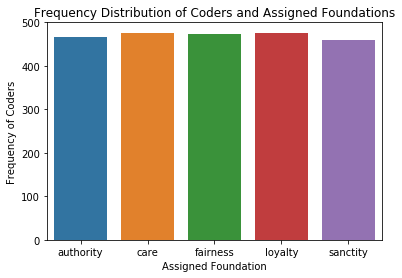

In [8]:
sns.barplot(x='assigned_domain', y='coder_id', data = hl.groupby('assigned_domain').nunique().T.loc['coder_id'].T.reset_index())
plt.ylabel('Frequency of Coders')
plt.xlabel('Assigned Foundation')
plt.title('Frequency Distribution of Coders and Assigned Foundations')

How many foundations have been coded for each document?

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Frequency Distribution of Coded Foundations per Document')

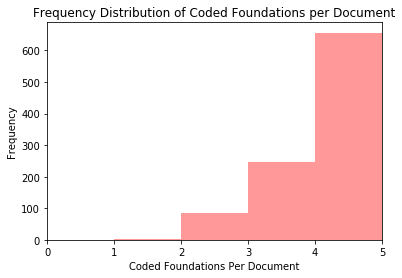

In [9]:
sns.distplot(hl.groupby(hl.document_id).nunique().assigned_domain, kde=False, bins=4, color='r')
plt.xlim(0,5,1)
plt.xlabel('Coded Foundations Per Document')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Coded Foundations per Document')

How many coders have been assigned per document?

Text(0.5,1,'Frequency Distribution of Coders per Document')

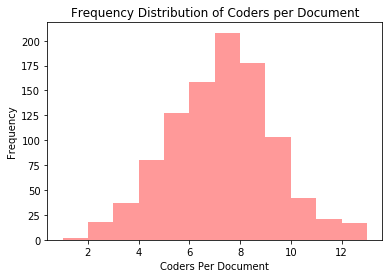

In [10]:
sns.distplot(hl.groupby(hl.document_id).nunique().coder_id, kde=False, bins=12, color='r')
plt.xlabel('Coders Per Document')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Coders per Document')

How many highlights have been genereated for each foundation?

Text(0.5,1,'Frequency Distribution of Produced Highlights per Foundation')

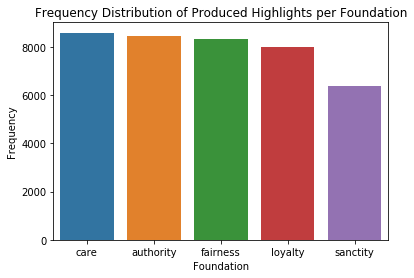

In [11]:
sns.countplot(hl.assigned_domain,  order=hl.assigned_domain.value_counts().index)
plt.ylabel("Frequency")
plt.xlabel("Foundation")
plt.title('Frequency Distribution of Produced Highlights per Foundation')

What is the mean sentiment across highlights?

Text(0.5,1,'Average Sentiment Across Highlights')

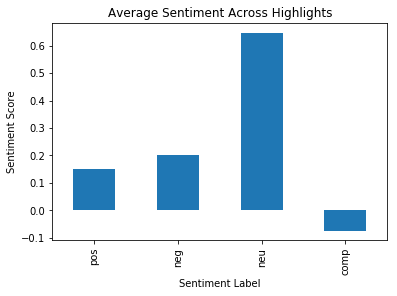

In [12]:
hl[['pos','neg','neu','comp']].mean().plot(kind='bar')
plt.ylabel('Sentiment Score')
plt.xlabel('Sentiment Label')
plt.title('Average Sentiment Across Highlights')

What is the mean sentiment per highlighted foundation?

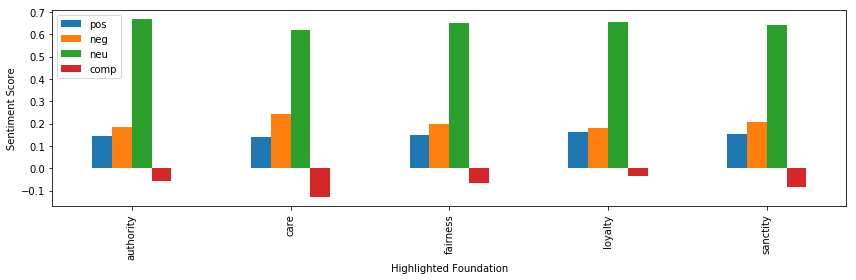

In [13]:
fig, ax = plt.subplots(figsize=(12,4))
hl[['pos','neg','neu','comp','assigned_domain']].groupby('assigned_domain').mean().plot(kind='bar', ax=ax)
plt.ylabel('Sentiment Score')
plt.xlabel('Highlighted Foundation')
plt.tight_layout()

## Construct Vocabulary

In the following steps, we construct the `vocabulary`. This vocabulary is a DataFrame that is indexed by each unique word that is found in the processed `hl`.

In [14]:
tokens = [token for highlight in hl.tokens.values for token in highlight]
print('Total number of words in highlights:', len(tokens))

Total number of words in highlights: 284114


In [15]:
vocab = set(tokens)
vocab = [x.lower() for x in vocab]
vocab = [x for x in vocab if len(x) >= 3]

vocab = [x for x in vocab if x not in stopwords]

vocab = pd.DataFrame(vocab)
vocab = vocab.rename(columns={0:'word'})

# Remove words with numbers 
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

def hasPunct(inputString):
    if any(char in punctuation for char in inputString):
        return 'True'
    else:
        return 'False'

vocab['has_number'] = vocab.word.apply(lambda x: hasNumbers(x))
vocab['has_punct'] = vocab.word.apply(lambda x: hasPunct(x))

vocab = vocab[np.logical_and(vocab['has_number']==False, vocab['has_punct']=='False')]

del vocab['has_number']
del vocab['has_punct']

foundations = ['care','fairness','loyalty','authority','sanctity']

for f in foundations:
    vocab[str(f)] = 0.0

vocab.index = vocab.word
vocab['sent'] = 0.0

print('Final vocabulary size after preprocessing:', len(vocab))

Final vocabulary size after preprocessing: 17324


In [16]:
vocab.head()

,word,care,fairness,loyalty,authority,sanctity,sent
word,,,,,,,
obscenity,obscenity,0.0,0.0,0.0,0.0,0.0,0.0
fate,fate,0.0,0.0,0.0,0.0,0.0,0.0
mass,mass,0.0,0.0,0.0,0.0,0.0,0.0
sewer,sewer,0.0,0.0,0.0,0.0,0.0,0.0
expunge,expunge,0.0,0.0,0.0,0.0,0.0,0.0


### How many times has a word in the vocabulary been seen by (a) ALL coders and (b) by coders with a certain foundation?

#### 1) How often does each word appear in each document

In the cell below, we read in all the news articles that were seen and coded by the human coders. We then preprocess the document text by removing punctuations and stopwords. In a final step, we compute the frequency with which each word appeared in each document.

In [17]:
# Get the documents
hl_docs = pd.read_pickle('data/coded_news.pkl')
corpus = hl_docs[hl_docs.index.isin(hl.document_id)]
corpus['text'] = corpus['text'].str.lower()

def preprocess(text):
    raw_text = text
    for s in punctuation:
        raw_text = raw_text.replace(s,'')
    for s in stopwords:
        regex = re.compile(r"\b{}\b".format(s))
        raw_text = re.sub(regex, '', raw_text)
    raw_text = raw_text.replace('\'','')
    raw_text = raw_text.strip()
    raw_text = " ".join(raw_text.split())
    return raw_text

corpus['text'] = corpus['text'].apply(lambda x:preprocess(x))

# Calculate term frequency
vec = CountVectorizer(stop_words=stopwords)
X = vec.fit_transform(corpus['text'])
word_per_doc = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
word_per_doc.index = corpus.index
word_per_doc = word_per_doc.T
word_per_doc = word_per_doc.reset_index().rename(columns={'index':'word'})
word_per_doc = word_per_doc[word_per_doc.word.isin(vocab.word)]
word_per_doc = word_per_doc.set_index('word').T
word_per_doc = word_per_doc.fillna(0)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The result is a D x W matrix where D = number of unique documents and W = number of unique words. Each cell in that matrix captures how often that word appeared in that document.

In [18]:
word_per_doc.head()

word,aback,abandon,abandoned,abandoning,abandonment,abdication,abdomen,abducted,abducting,abducts,...,zinc,zingers,zombies,zone,zoned,zones,zoning,zoo,zoom,zooming
4877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4881,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4887,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4890,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 2) How many coders saw each document?

In the following, we determine the total number of coders that have seen each document (see the `total_seen` column on the right.)

In [19]:
coders_per_doc = hl.groupby('document_id').nunique()['coder_id']
coders_per_doc = coders_per_doc.fillna(0)

In [20]:
# Join these and multiply these with the above raw counts to get the total_seen variable 
total_seen = word_per_doc.join(coders_per_doc.rename('total_seen'))
total_seen[[c for c in total_seen.columns if c != 'total_seen']] = total_seen[[c for c in total_seen.columns if c != 'total_seen']].multiply(total_seen['total_seen'], axis=0)

In [21]:
total_seen.head()

,aback,abandon,abandoned,abandoning,abandonment,abdication,abdomen,abducted,abducting,abducts,...,zingers,zombies,zone,zoned,zones,zoning,zoo,zoom,zooming,total_seen
4877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
4879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
4881,0,0,9,0,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
4887,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
4890,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [22]:
# Now, get the column sum to obtain total number of times this word was seen by coders across documents and add that variable to the vocabulary
vocab = vocab.join(total_seen[[c for c in total_seen.columns if c != 'total_seen']].sum().rename('total_seen'))

#### 3) How often was each word seen by coders with a given foundation?

Next up, we determine how often each word has been seen by a coder with a certain assigned foundation.

In [23]:
# Every unique coder is assigned a foundation per document 
# Question: for each document, get mapping of coder_id and assigned foundation 

# Make dataframe that is indexed by each document id
# Loop over each document and get the coders and their assigned foundation 
seen_by_foundation = pd.DataFrame(index=corpus.index, columns=['seen_care', 'seen_fairness','seen_loyalty','seen_authority','seen_sanctity'])

In [24]:
seen_by_foundation.head()

,seen_care,seen_fairness,seen_loyalty,seen_authority,seen_sanctity
4877,NaN,NaN,NaN,NaN,NaN
4879,NaN,NaN,NaN,NaN,NaN
4881,NaN,NaN,NaN,NaN,NaN
4887,NaN,NaN,NaN,NaN,NaN
4890,NaN,NaN,NaN,NaN,NaN


In [25]:
# In a first step, loop over the unique documents
doc_ids = seen_by_foundation.index.unique()
for doc_id in doc_ids:
    # Select all the hls that correspond to that doc_id
    document = hl[hl['document_id'] == doc_id]
    # Obtain the unique coder_ids per document and their assigned foundations
    coders_foundation = document.groupby('assigned_domain').nunique()['coder_id']
    # Join these counts with the seen_by_foundation dataframe
    try:
        seen_by_foundation.at[doc_id, 'seen_care'] = coders_foundation.care
    except:
        pass
    try:
        seen_by_foundation.at[doc_id, 'seen_fairness'] = coders_foundation.fairness
    except:
        pass
    try:
        seen_by_foundation.at[doc_id, 'seen_loyalty'] = coders_foundation.loyalty
    except:
        pass
    try:
        seen_by_foundation.at[doc_id, 'seen_authority'] = coders_foundation.authority
    except:
        pass
    try:
        seen_by_foundation.at[doc_id, 'seen_sanctity'] = coders_foundation.sanctity
    except:
        pass

In [26]:
seen_by_foundation = seen_by_foundation.fillna(0)

In [27]:
seen_by_foundation.head()

,seen_care,seen_fairness,seen_loyalty,seen_authority,seen_sanctity
4877,0,2,1,3,2
4879,1,1,2,2,0
4881,2,3,1,0,3
4887,2,2,2,1,1
4890,1,0,0,0,2


So, document 4877 was coded by 2 fairness coders, 1 loyalty, 3 authority, and 2 sanctity coders

In [28]:
# Join the coders per foundation with the word counts per document
seen_by_foundation = seen_by_foundation.join(word_per_doc)

In [29]:
seen_by_foundation.head()

,seen_care,seen_fairness,seen_loyalty,seen_authority,seen_sanctity,aback,abandon,abandoned,abandoning,abandonment,...,zinc,zingers,zombies,zone,zoned,zones,zoning,zoo,zoom,zooming
4877,0,2,1,3,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4879,1,1,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4881,2,3,1,0,3,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4887,2,2,2,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4890,1,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
seen_cols = [c for c in seen_by_foundation.columns if c.startswith('seen_')]

In [31]:
# Multiply each word count by the total sum of foundation-coders that saw this word
for seen_f in seen_cols:
    word_seen_vec = pd.DataFrame(seen_by_foundation[[seen_f]+[c for c in seen_by_foundation.columns if not c.startswith('seen_')]][[c for c in seen_by_foundation.columns if not c.startswith('seen_')]].apply(lambda x: x * seen_by_foundation[seen_f]).sum().rename(seen_f))
    vocab = vocab.join(word_seen_vec)

In [32]:
vocab.head()

,word,care,fairness,loyalty,authority,sanctity,sent,total_seen,seen_care,seen_fairness,seen_loyalty,seen_authority,seen_sanctity
word,,,,,,,,,,,,,
obscenity,obscenity,0.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,1.0,2.0,1.0,4.0
fate,fate,0.0,0.0,0.0,0.0,0.0,0.0,121.0,24.0,30.0,22.0,24.0,22.0
mass,mass,0.0,0.0,0.0,0.0,0.0,0.0,661.0,131.0,139.0,129.0,151.0,111.0
sewer,sewer,0.0,0.0,0.0,0.0,0.0,0.0,17.0,5.0,1.0,4.0,4.0,3.0
expunge,expunge,0.0,0.0,0.0,0.0,0.0,0.0,13.0,1.0,4.0,3.0,3.0,2.0


As can be seen from the above vocabulary, we now know that the word obscenity was seen a total of 9 times across all coders. Respectively, convoy has been seen by 1 care-coder, 1 fairness-coder, and so on.

In [33]:
vocab = vocab.dropna(subset=['total_seen'])
vocab = vocab[vocab.total_seen > 0]

In [34]:
del vocab['sent']

In [35]:
vocab['pos_sent'] = 0.0
vocab['neg_sent'] = 0.0
vocab['comp_sent'] = 0.0

### 4) Score Vocabulary

As a first step in scoring the vocabulary, we iterate over all highlights. Once a word is found in the vocabulary, we first obtain the foundation of the highlight where this word was mentioned. Then, in the vocabulary, we go to the column that reflects this foundation and increment a `1`. By doing so, we create a vocabulary that reflects how often a certain word appeared in highlights with a certain foundation.

In [36]:
# Iterate over each word in each highlight and increment foundation counts
# Transform vocab into dictionary for faster hash functionality
words = {k:0.0 for k in vocab.index} 

for i,row in hl.iterrows():

    highlight = row.tokens
    found = row.assigned_domain 
    comp = row.comp
    pos = row.pos
    neg = row.neg
    
    for word in highlight:
        if word in words.keys():
            vocab.at[str(word),found] += 1
            vocab.at[str(word),'pos_sent'] += pos
            vocab.at[str(word),'neg_sent'] += neg
            vocab.at[str(word),'comp_sent'] += comp

vocab['sum_hl'] = vocab[foundations].sum(axis=1)
vocab = vocab.fillna(0)

In [37]:
vocab = vocab[vocab.sum_hl > 0]

In [38]:
foundations = ['care','fairness','loyalty','authority','sanctity']

### 5) Divide highlight counts by seen_by Columns

In the next step, we divide the total frequency a word has been highlighted with a certain foundation by the number of times this word has been seen by coders who were assigned that foundation. Doing so yields us a probabality that a word was highlighted by a coder. As an example, if the word `kill` has .8 in the Care_norm column, then this means that there is a 80% probability that `kill` was highlighted by a coder assigned the Care foundation.

In [39]:
for i,row in vocab.iterrows():
    if row.seen_care != 0:
        vocab.at[i, 'care_norm'] = row.care / row.seen_care
    if row.seen_fairness != 0:
        vocab.at[i, 'fairness_norm'] = row.fairness / row.seen_fairness
    if row.seen_authority != 0:
        vocab.at[i, 'authority_norm'] = row.authority / row.seen_authority
    if row.seen_loyalty != 0:
        vocab.at[i, 'loyalty_norm'] = row.loyalty / row.seen_loyalty
    if row.seen_sanctity != 0:
        vocab.at[i, 'sanctity_norm'] = row.sanctity / row.seen_sanctity
    if row.sum_hl != 0 and row.total_seen != 0:
        vocab.at[i, 'moral'] = row.sum_hl / row.total_seen

In [40]:
vocab = vocab.fillna(0)

In [41]:
# Define aggregated columns
weights_f = [c for c in vocab.columns if c.endswith('_norm')]
senti_cols = [c for c in vocab.columns if c.endswith('sent')]

In [42]:
# Average sentiment scores by dividing aggregate sentiment scores with the number of highlights that word appeared in 
vocab[senti_cols] = vocab[senti_cols].divide(vocab['sum_hl'], axis=0)

In [43]:
# Remove words whose probabilities are above 1 for any given foundation (caused by minor preprocessing glitches)
vocab = vocab[(vocab['care_norm'] <= 1) & (vocab['fairness_norm'] <= 1) & (vocab['authority_norm'] <= 1) & (vocab['loyalty_norm'] <= 1) & (vocab['sanctity_norm'] <= 1)] 

In [44]:
# Ensure each word has been seen at least 10 times by any foundation coder
vocab = vocab[(vocab['seen_care'] > 10) & (vocab['seen_fairness'] > 10) & (vocab['seen_loyalty'] > 10) & (vocab['seen_authority'] > 10) & (vocab['seen_sanctity'] > 10)] 

In [45]:
# Ensure each word has been highlighted at least 5 times with any foundation
vocab = vocab.iloc[pd.np.where(vocab[['care', 'fairness', 'loyalty','authority','sanctity']].ge(5).any(1, skipna=True))]

In [47]:
# Filter out words whose variance across foundation probabilities is smaller than the 10th quartile.
vocab['var'] = vocab[weights_f].var(axis=1)
vocab = vocab[vocab['var'] > vocab['var'].quantile(0.1)]

In [49]:
# Score Sentiment of each unique word with VADER
vocab['ind_vader'] = vocab.word.apply(lambda x: analyzer.polarity_scores(x)) 
vocab['ind_comp'] = vocab['ind_vader'].apply(pd.Series)['compound']

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Add most likely POS tag for each word:

In [50]:
import nltk 
from nltk.corpus import brown

In [51]:
fd = nltk.FreqDist(brown.words())
cfd = nltk.ConditionalFreqDist(brown.tagged_words())
most_freq_words = fd.most_common()
likely_tags = dict((word, cfd[word].max()) for (word, _) in most_freq_words)
baseline_tagger = nltk.UnigramTagger(model=likely_tags)

In [52]:
vocab['tag'] = vocab['word'].apply(lambda x: baseline_tagger.tag([x]))
vocab['tag'] = vocab['tag'].apply(lambda y: [x[1] for x in y])

for i,row in vocab.iterrows():
    if row.tag[0] == None:
        vocab.at[i, 'tag'] = 'None'

vocab['tag'] = vocab['tag'].apply(lambda y: y[0])

for i,row in vocab.iterrows():
    if row.tag == 'NN' or row.tag == 'NNS':
        vocab.at[i, 'tag'] = 'n'
    if row.tag == 'VBN' or row.tag == 'VBZ' or row.tag == 'VBD' or row.tag == 'VB' or row.tag == 'VBG':
        vocab.at[i, 'tag'] = 'v'
    if row.tag == 'JJ':
        vocab.at[i, 'tag'] = 'a'
    if row.tag == 'RB':
        vocab.at[i, 'tag'] = 'r'
    if row.tag == 'N':
        vocab.at[i, 'tag'] = 'n'
        
pos_tags = ['n','v','a','r']
vocab = vocab[vocab.tag.isin(pos_tags)]

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

Delete words with neutral sentiment and create dictionary for context-indpendent use cases such as Affect Misattribution Procedures or Lexical Decision Tasks.

In [53]:
amp = vocab[vocab['ind_comp'] != 0]

In [54]:
print('Size of E-MFD with neutral words removed:', len(amp))

Size of E-MFD with neutral words removed: 729


In [55]:
amp.to_pickle('dictionaries/emfd_amp.pkl')

In [56]:
vocab.to_pickle('dictionaries/emfd_scoring.pkl')